In [1]:
import argparse
import glob
import json
import multiprocessing
import os
import random
import re
from importlib import import_module
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import MaskBaseDataset
from loss import create_criterion

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [3]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [4]:
def grid_image(np_images, gts, preds, n=16, shuffle=False):
    batch_size = np_images.shape[0]
    assert n <= batch_size

    choices = random.choices(range(batch_size), k=n) if shuffle else list(range(n))
    figure = plt.figure(figsize=(12, 18 + 2))  # cautions: hardcoded, 이미지 크기에 따라 figsize 를 조정해야 할 수 있습니다. T.T
    plt.subplots_adjust(top=0.8)               # cautions: hardcoded, 이미지 크기에 따라 top 를 조정해야 할 수 있습니다. T.T
    n_grid = np.ceil(n ** 0.5)
    tasks = ["mask", "gender", "age"]
    for idx, choice in enumerate(choices):
        gt = gts[choice].item()
        pred = preds[choice].item()
        image = np_images[choice]
        # title = f"gt: {gt}, pred: {pred}"
        gt_decoded_labels = MaskBaseDataset.decode_multi_class(gt)
        pred_decoded_labels = MaskBaseDataset.decode_multi_class(pred)
        title = "\n".join([
            f"{task} - gt: {gt_label}, pred: {pred_label}"
            for gt_label, pred_label, task
            in zip(gt_decoded_labels, pred_decoded_labels, tasks)
        ])

        plt.subplot(n_grid, n_grid, idx + 1, title=title)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)

    return figure

In [5]:
def increment_path(path, exist_ok=False):
    """ Automatically increment path, i.e. runs/exp --> runs/exp0, runs/exp1 etc.

    Args:
        path (str or pathlib.Path): f"{model_dir}/{args.name}".
        exist_ok (bool): whether increment path (increment if False).
    """
    path = Path(path)
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}*")
        matches = [re.search(rf"%s(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]
        n = max(i) + 1 if i else 2
        return f"{path}{n}"

In [6]:
def train(data_dir, model_dir, args):
    seed_everything(args.seed)

    save_dir = increment_path(os.path.join(model_dir, args.name))

    # -- settings
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # -- dataset
    dataset_module = getattr(import_module("dataset"), args.dataset)  # default: BaseAugmentation
    dataset = dataset_module(
        data_dir=data_dir,
    )


    # -- augmentation
    transform_module = getattr(import_module("dataset"), args.augmentation)  # default: BaseAugmentation
    transform = transform_module(
        resize=args.resize,
        mean=dataset.mean,
        std=dataset.std,
    )
    dataset.set_transform(transform)

    # -- data_loader
    train_set, val_set = dataset.split_dataset()

    train_loader = DataLoader(
        train_set,
        batch_size=args.batch_size,
        num_workers=multiprocessing.cpu_count()//2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_set,
        batch_size=args.valid_batch_size,
        num_workers=multiprocessing.cpu_count()//2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

    # -- model
    Generator_module = getattr(import_module("model"), args.Generator)  # default: BaseModel
    Generator = Generator_module().to(device)
    Generator = torch.nn.DataParallel(Generator)
    
    Discriminator_module = getattr(import_module("model"), args.Discriminator)  # default: BaseModel
    Discriminator = Discriminator_module().to(device)
    Discriminator = torch.nn.DataParallel(Discriminator)
    
    # -- loss & metric
    binary_criterion = create_criterion(args.binary_criterion)  # default: cross_entropy
    L1_criterion = create_criterion(args.L1_criterion)
    opt_module = getattr(import_module("torch.optim"), args.optimizer)  # default: SGD
    Generator_optimizer = opt_module(
        filter(lambda p: p.requires_grad, Generator.parameters()),
        lr=args.lr,
        weight_decay=5e-4
    )
    Generator_scheduler = StepLR(Generator_optimizer, args.lr_decay_step, gamma=0.5)
    
    Discriminator_optimizer = opt_module(
        filter(lambda p: p.requires_grad, Discriminator.parameters()),
        lr=args.lr,
        weight_decay=5e-4
    )
    Discriminator_scheduler = StepLR(Discriminator_optimizer, args.lr_decay_step, gamma=0.5)
    
    # -- logging
    logger = SummaryWriter(log_dir=save_dir)
    with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(vars(args), f, ensure_ascii=False, indent=4)

    best_val_acc = 0
    best_val_loss = np.inf
    
    img_shape=args.resize
    disc_patch=(1,img_shape[0]//16,img_shape[1]//16)
    
    valid = torch.ones((64,)+disc_patch)
    fake = torch.zeros((64,)+disc_patch)
    
    valid=valid.to(device)
    fake=fake.to(device)
    
    for epoch in range(args.epochs):
        # train loop
        Generator.train()
        Discriminator.train()
        
        Generator_loss_value = 0
        Discriminator_loss_value = 0
        matches = 0
        for idx, train_batch in enumerate(train_loader):
            mask_img, no_mask_img = train_batch
            ###################################################
            mask_img = mask_img.to(device)
            no_mask_img = no_mask_img.to(device)

            Generator_optimizer.zero_grad()
            Discriminator_optimizer.zero_grad()

            fake_img = Generator(mask_img)   # 64, 3 128, 96
            

            
            d_real=Discriminator(no_mask_img)
            d_fake=Discriminator(fake_img)
            
            d_loss_real=binary_criterion(d_real,valid)
            d_loss_fake=binary_criterion(d_fake,fake)
            
            d_loss=0.5*(d_loss_real+d_loss_fake)
            
            g_loss=L1_criterion(fake_img,no_mask_img)
            
            loss=g_loss+d_loss
            loss.backward()
            
            Generator_optimizer.step()
            Discriminator_optimizer.step()

            loss_value = loss.item()
            
            if (idx + 1) % args.log_interval == 0:
                train_loss = loss_value / args.log_interval

                print(
                    f"Epoch[{epoch}/{args.epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss {train_loss:4.4} "
                )
                logger.add_scalar("Train/loss", train_loss, epoch * len(train_loader) + idx)
                
                loss_value = 0

        Generator_scheduler.step()
        Discriminator_scheduler.step()
        
        ######################################################################
        
        if epoch%10==0:
            r,c=1,3
            fig, axs = plt.subplots(r, c)
            axs[0].imshow(mask_img[0].detach().cpu().permute(1,2,0))
            axs[1].imshow(fake_img[0].detach().cpu().permute(1,2,0))
            axs[2].imshow(no_mask_img[0].detach().cpu().permute(1,2,0))
            plt.show()
            
        ####################################################################################
        # val loop
        # 생성자가 최고인 것만 생성자만 저장하겠음
        with torch.no_grad():
            print("Calculating validation results...")
            Generator.eval()
            Discriminator.eval()
            
            val_loss_items = []


            for val_batch in val_loader:
                mask_img, no_mask_img = val_batch
                mask_img = mask_img.to(device)
                no_mask_img = no_mask_img.to(device)

                fake_img = Generator(mask_img)


                g_loss_item = L1_criterion(fake_img, no_mask_img).item()
                val_loss_items.append(g_loss_item)


            val_loss = np.sum(val_loss_items) / len(val_loader)
            best_val_loss = min(best_val_loss, val_loss)
            
            if val_loss > best_val_loss:
                print(f"New best model for val loss : {val_loss:4.2%}! saving the best model..")
                torch.save(Generator.module.state_dict(), f"{save_dir}/best.pth")
                best_val_loss = val_loss
            torch.save(Generator.module.state_dict(), f"{save_dir}/last.pth")
            print(
                f"loss: {val_loss:4.2} || "
                f"best loss: {best_val_loss:4.2}"
            )
            logger.add_scalar("Val/loss", val_loss, epoch)

            print()

In [7]:
import easydict
args=easydict.EasyDict({
    'seed':42,
    'epochs':500,
    'dataset':'CycleDataset',
    'augmentation':'BaseAugmentation',
    'resize':[128,96],
    'batch_size':64,
    'valid_batch_size':1000,
    
    'model':'BaseModel',
    'Generator':'Generator',
    'Discriminator':'Discriminator',
    
    'optimizer':'Adam',
    'lr':1e-3,
    'val_ratio':0.2,
    
    'cross_criterion':'cross_entropy',
    'binary_criterion':'binary_cross_entropy',
    'mse_criterion':'mse_loss',
    'L1_criterion':'L1_loss',
    
    'lr_decay_step':20,
    'log_interval':500,
    'name':'exp',
    'data_dir':os.environ.get('SM_CHANNEL_TRAIN', '/opt/ml/input/data/train/images'),
    'model_dir':os.environ.get('SM_MODEL_DIR', './model')
})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


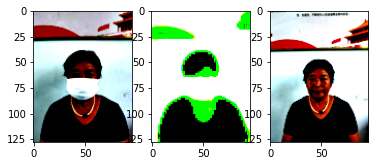

Calculating validation results...
loss: 0.68 || best loss: 0.68

Calculating validation results...
New best model for val loss : 85.61%! saving the best model..
loss: 0.86 || best loss: 0.86

Calculating validation results...
loss: 0.64 || best loss: 0.64

Calculating validation results...
loss: 0.62 || best loss: 0.62

Calculating validation results...
loss:  0.6 || best loss:  0.6

Calculating validation results...
New best model for val loss : 63.18%! saving the best model..
loss: 0.63 || best loss: 0.63

Calculating validation results...
loss: 0.61 || best loss: 0.61

Calculating validation results...
loss: 0.55 || best loss: 0.55

Calculating validation results...
loss: 0.53 || best loss: 0.53

Calculating validation results...
loss: 0.52 || best loss: 0.52



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


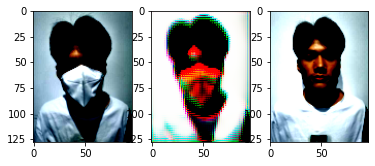

Calculating validation results...
New best model for val loss : 57.06%! saving the best model..
loss: 0.57 || best loss: 0.57

Calculating validation results...
loss: 0.51 || best loss: 0.51

Calculating validation results...
New best model for val loss : 51.10%! saving the best model..
loss: 0.51 || best loss: 0.51

Calculating validation results...
New best model for val loss : 86.43%! saving the best model..
loss: 0.86 || best loss: 0.86

Calculating validation results...
New best model for val loss : 96.65%! saving the best model..
loss: 0.97 || best loss: 0.97

Calculating validation results...
loss: 0.65 || best loss: 0.65

Calculating validation results...
loss: 0.57 || best loss: 0.57

Calculating validation results...
loss: 0.53 || best loss: 0.53

Calculating validation results...
loss: 0.52 || best loss: 0.52

Calculating validation results...
New best model for val loss : 52.18%! saving the best model..
loss: 0.52 || best loss: 0.52



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


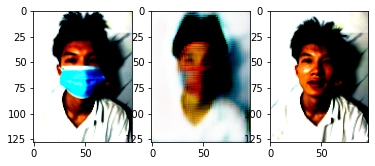

Calculating validation results...
loss: 0.51 || best loss: 0.51

Calculating validation results...
New best model for val loss : 51.33%! saving the best model..
loss: 0.51 || best loss: 0.51

Calculating validation results...
loss:  0.5 || best loss:  0.5

Calculating validation results...
loss:  0.5 || best loss:  0.5

Calculating validation results...
New best model for val loss : 49.85%! saving the best model..
loss:  0.5 || best loss:  0.5

Calculating validation results...
New best model for val loss : 50.23%! saving the best model..
loss:  0.5 || best loss:  0.5

Calculating validation results...
loss:  0.5 || best loss:  0.5

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
New best model for val loss : 49.82%! saving the best model..
loss:  0.5 || best loss:  0.5

Calculating validation results...
loss: 0.49 || best loss: 0.49



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


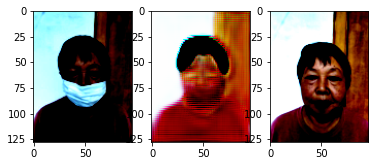

Calculating validation results...
New best model for val loss : 49.97%! saving the best model..
loss:  0.5 || best loss:  0.5

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
New best model for val loss : 48.94%! saving the best model..
loss: 0.49 || best loss: 0.49

Calculating validation results...
New best model for val loss : 49.03%! saving the best model..
loss: 0.49 || best loss: 0.49

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
New best model for val loss : 64.42%! saving the best model..
loss: 0.64 || best loss: 0.64

Calculating validation results...
loss: 0.54 || best loss: 0.54

Calculating validation results...
loss: 0.52 || best loss: 0.52

Calculating validation results...
loss: 0.51 || best loss: 0.51



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


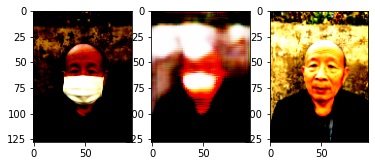

Calculating validation results...
loss:  0.5 || best loss:  0.5

Calculating validation results...
New best model for val loss : 50.29%! saving the best model..
loss:  0.5 || best loss:  0.5

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
New best model for val loss : 51.93%! saving the best model..
loss: 0.52 || best loss: 0.52

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
New best model for val loss : 48.73%! saving the best model..
loss: 0.49 || best loss: 0.49

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
loss: 0.48 || best loss: 0.48

Calculating validation results...
New best model for val loss : 49.15%! saving the best model..
loss: 0.49 || best loss: 0.49



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


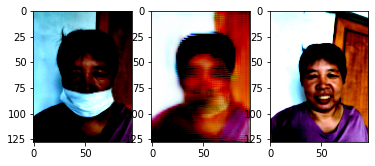

Calculating validation results...
loss: 0.49 || best loss: 0.49

Calculating validation results...
loss: 0.48 || best loss: 0.48

Calculating validation results...
New best model for val loss : 48.40%! saving the best model..
loss: 0.48 || best loss: 0.48

Calculating validation results...
loss: 0.48 || best loss: 0.48

Calculating validation results...
New best model for val loss : 47.80%! saving the best model..
loss: 0.48 || best loss: 0.48

Calculating validation results...
loss: 0.48 || best loss: 0.48

Calculating validation results...
New best model for val loss : 47.85%! saving the best model..
loss: 0.48 || best loss: 0.48

Calculating validation results...
loss: 0.47 || best loss: 0.47

Calculating validation results...
loss: 0.47 || best loss: 0.47

Calculating validation results...
New best model for val loss : 47.98%! saving the best model..
loss: 0.48 || best loss: 0.48



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


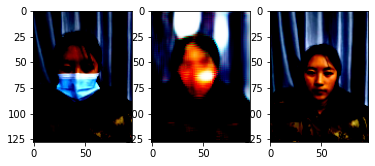

Calculating validation results...
loss: 0.47 || best loss: 0.47

Calculating validation results...
loss: 0.47 || best loss: 0.47

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
New best model for val loss : 46.54%! saving the best model..
loss: 0.47 || best loss: 0.47

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.46 || best loss: 0.46



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


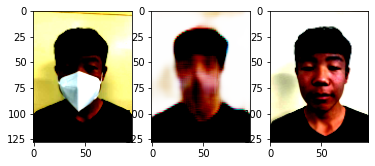

Calculating validation results...
New best model for val loss : 45.86%! saving the best model..
loss: 0.46 || best loss: 0.46

Calculating validation results...
New best model for val loss : 47.09%! saving the best model..
loss: 0.47 || best loss: 0.47

Calculating validation results...
loss: 0.46 || best loss: 0.46

Calculating validation results...
New best model for val loss : 45.61%! saving the best model..
loss: 0.46 || best loss: 0.46

Calculating validation results...
New best model for val loss : 46.11%! saving the best model..
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.45 || best loss: 0.45

Calculating validation results...
New best model for val loss : 45.32%! saving the best model..
loss: 0.45 || best loss: 0.45

Calculating validation results...
New best model for val loss : 45.53%! saving the best model..
loss: 0.46 || best loss: 0.46

Calculating validation results...
loss: 0.45 || best loss: 0.45

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


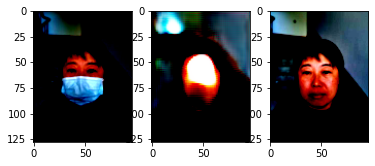

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 44.18%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.89%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 44.07%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.74%! saving the best model..
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


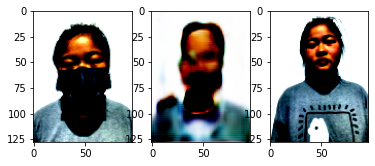

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.69%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.66%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


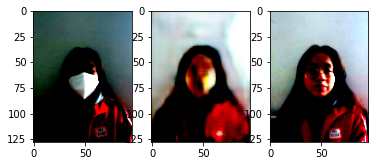

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.99%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.11%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.95%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.19%! saving the best model..
loss: 0.43 || best loss: 0.43



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


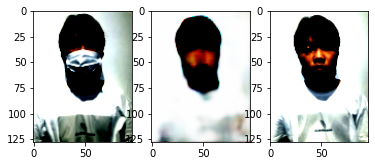

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.99%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.01%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.00%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.97%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.01%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


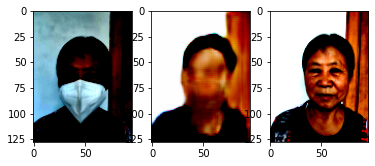

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.75%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.80%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.80%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.84%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.86%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.90%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.94%! saving the best model..
loss: 0.43 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


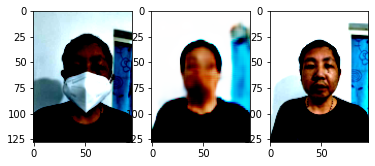

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.90%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.91%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.93%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.94%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.96%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.98%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


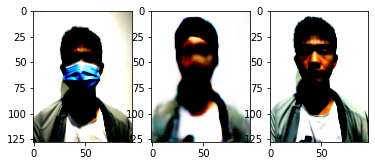

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.93%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.94%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 42.97%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.00%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.01%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.04%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.05%! saving the best model..
loss: 0.43 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


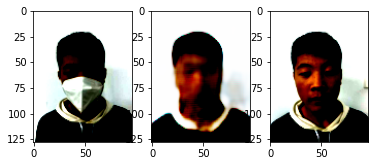

Calculating validation results...
New best model for val loss : 43.11%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.08%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.12%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.12%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.11%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.17%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


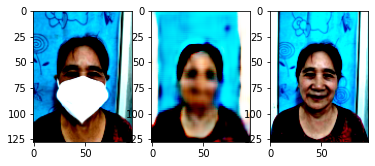

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.14%! saving the best model..
loss: 0.43 || best loss: 0.43

New best model for val loss : 43.15%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.18%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.19%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.22%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.22%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.23%! savin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


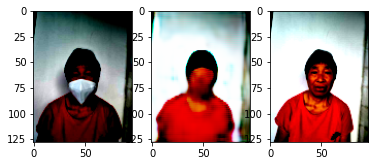

Calculating validation results...
New best model for val loss : 43.27%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.27%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.28%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.29%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.29%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.30%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.33%! saving the best model..
loss: 0.43 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


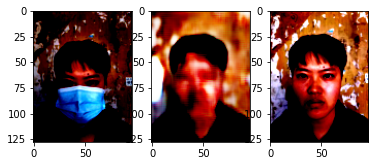

Calculating validation results...
New best model for val loss : 43.32%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.34%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.35%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.35%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.36%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.38%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.38%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


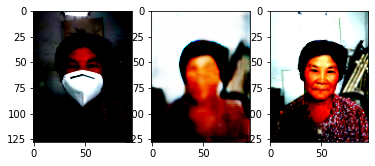

Calculating validation results...
New best model for val loss : 43.40%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.41%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.40%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.43%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.43%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.44%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


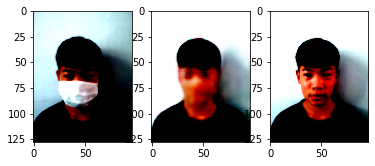

Calculating validation results...
New best model for val loss : 43.45%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.45%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.46%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.46%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.47%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.46%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.48%! saving the best model..
loss: 0.43 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


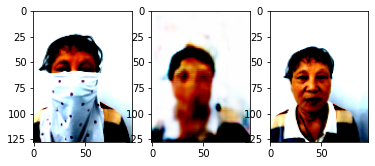

Calculating validation results...
New best model for val loss : 43.49%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.49%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.50%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.50%! saving the best model..
loss: 0.43 || best loss: 0.43

Calculating validation results...
New best model for val loss : 43.52%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.52%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


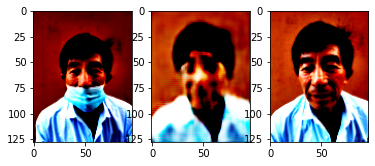

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.52%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.53%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.54%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.53%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.54%! saving the best model..
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


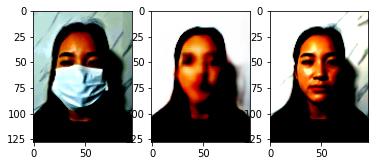

Calculating validation results...
New best model for val loss : 43.54%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.54%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.54%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.54%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.55%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.56%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


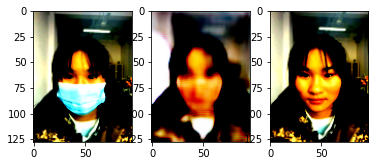

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.56%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.56%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.56%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.56%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.56%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.57%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


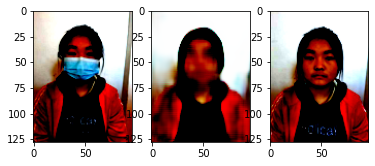

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.57%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.57%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.57%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.57%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


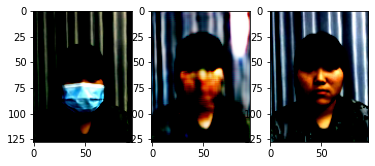

Calculating validation results...
New best model for val loss : 43.57%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


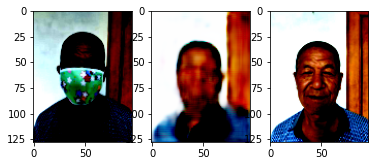

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.58%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


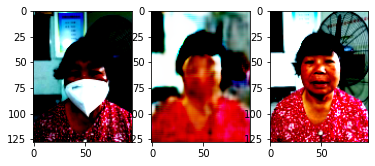

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


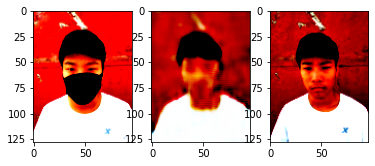

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


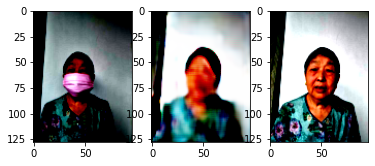

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


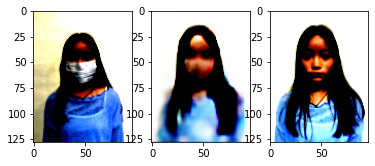

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


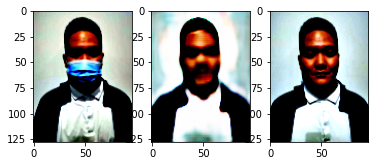

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


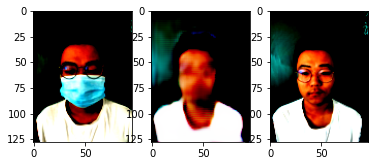

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


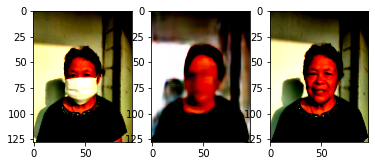

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


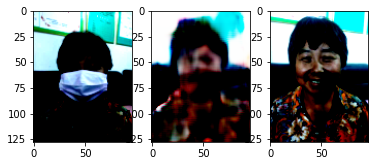

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


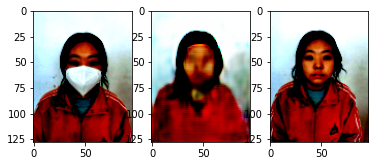

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


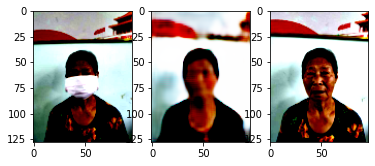

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


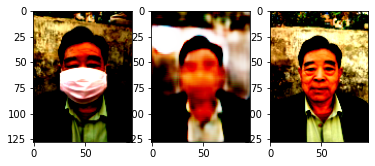

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


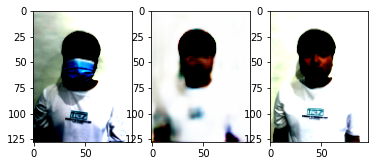

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


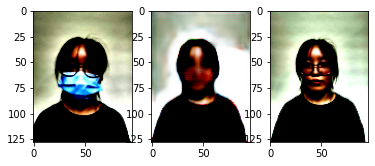

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


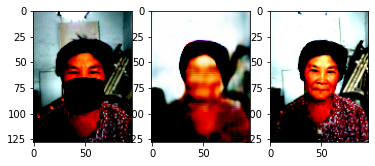

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


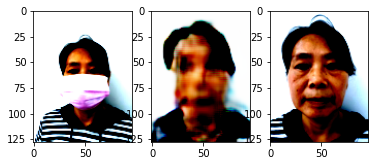

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


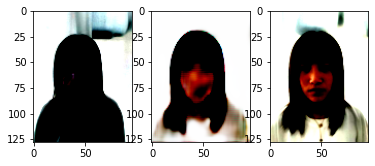

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


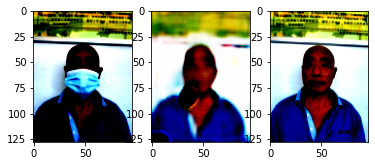

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


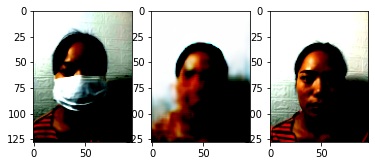

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


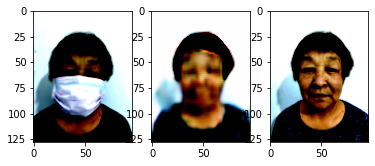

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


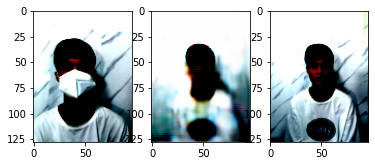

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
loss: 0.44 || best loss: 0.44

Calculating validation results...
New best model for val loss : 43.59%! saving the best model..
loss: 0.44 || best loss: 0.44



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


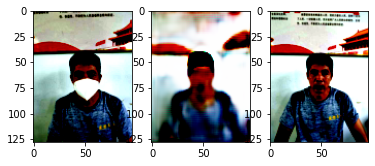

Calculating validation results...
loss: 0.44 || best loss: 0.44



In [ ]:
train('/opt/ml/input/data/train/images','./model',args)

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    from dotenv import load_dotenv
    import os
    load_dotenv(verbose=True)

    # Data and model checkpoints directories
    parser.add_argument('--seed', type=int, default=42, help='random seed (default: 42)')
    parser.add_argument('--epochs', type=int, default=1, help='number of epochs to train (default: 1)')
    parser.add_argument('--dataset', type=str, default='MaskBaseDataset', help='dataset augmentation type (default: MaskBaseDataset)')
    parser.add_argument('--augmentation', type=str, default='BaseAugmentation', help='data augmentation type (default: BaseAugmentation)')
    parser.add_argument("--resize", nargs="+", type=list, default=[128, 96], help='resize size for image when training')
    parser.add_argument('--batch_size', type=int, default=64, help='input batch size for training (default: 64)')
    parser.add_argument('--valid_batch_size', type=int, default=1000, help='input batch size for validing (default: 1000)')
    parser.add_argument('--model', type=str, default='BaseModel', help='model type (default: BaseModel)')
    parser.add_argument('--optimizer', type=str, default='SGD', help='optimizer type (default: SGD)')
    parser.add_argument('--lr', type=float, default=1e-3, help='learning rate (default: 1e-3)')
    parser.add_argument('--val_ratio', type=float, default=0.2, help='ratio for validaton (default: 0.2)')
    parser.add_argument('--criterion', type=str, default='cross_entropy', help='criterion type (default: cross_entropy)')
    parser.add_argument('--lr_decay_step', type=int, default=20, help='learning rate scheduler deacy step (default: 20)')
    parser.add_argument('--log_interval', type=int, default=20, help='how many batches to wait before logging training status')
    parser.add_argument('--name', default='exp', help='model save at {SM_MODEL_DIR}/{name}')

    # Container environment
    parser.add_argument('--data_dir', type=str, default=os.environ.get('SM_CHANNEL_TRAIN', '/opt/ml/input/data/train/images'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR', './model'))

    args = parser.parse_args()
    print(args)

    data_dir = args.data_dir
    model_dir = args.model_dir

    train(data_dir, model_dir, args)

In [ ]:
a=torch.ones((3,2,1))
a.shape